# Sprawozdanie: Analiza Optymalizatorów Gradientowych na Funkcji Rosenbrocka

## Cel badania
Porównanie zbieżności różnych algorytmów optymalizacji (GD, Momentum, Adam, Muon) dla funkcji Rosenbrocka z uwzględnieniem:
- Różnych punktów startowych
- Różnych współczynników uczenia się
- Różnych liczb iteracji (małe i duże step_size)


/tmp/ipykernel_56961/3731415807.py:13: RuntimeWarning: overflow encountered in scalar power
  dX = -2*(a - X) - 4*b*X*(Y - X**2)
/tmp/ipykernel_56961/3731415807.py:14: RuntimeWarning: overflow encountered in scalar power
  dY =  2*b*(Y - X**2)


Start x0 = (1.5, 1.5)
GD       : x_end=( nan,  nan)  f= nan
SGD      : x_end=( nan,  nan)  f= nan
Momentum : x_end=( 0.989868,  0.979109)  f= 0.000156
Nesterov : x_end=( 1.000560,  1.001004)  f= 0.000002
RMSProp  : x_end=( 1.006236,  1.027654)  f= 0.022970
Adam     : x_end=( 1.100681,  1.211784)  f= 0.010145
Muon     : x_end=( 0.995767,  0.975576)  f= 0.025543


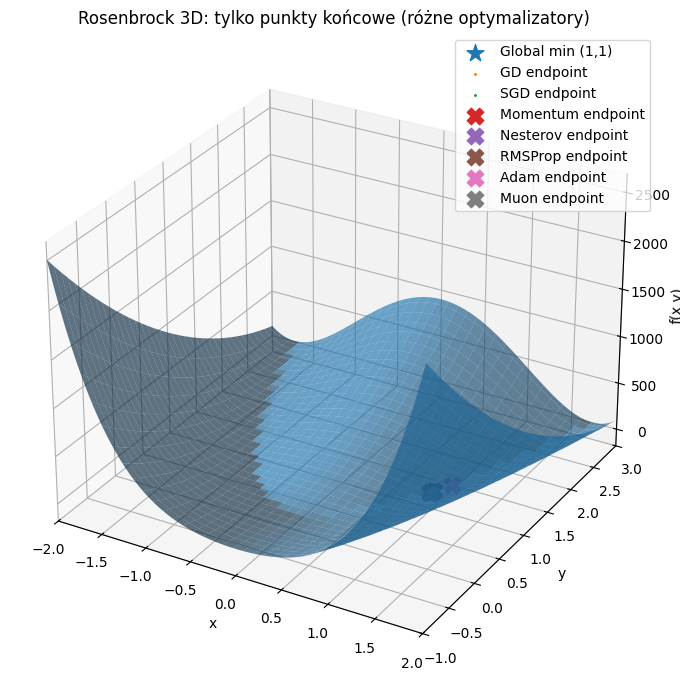

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Rosenbrock function + grad
# ----------------------------
def rosenbrock(x, a=1.0, b=100.0):
    X, Y = x[0], x[1]
    return (a - X)**2 + b*(Y - X**2)**2

def grad_rosenbrock(x, a=1.0, b=100.0):
    X, Y = x[0], x[1]
    dX = -2*(a - X) - 4*b*X*(Y - X**2)
    dY =  2*b*(Y - X**2)
    return np.array([dX, dY], dtype=float)

# ----------------------------
# Optimizers
# ----------------------------
def optimize(optimizer, x0, steps=8000, lr=1e-3, seed=0,
             noise_std=0.0,          # only for "SGD"-style
             beta=0.9,               # momentum / nesterov
             beta1=0.9, beta2=0.999, # adam
             rms_beta=0.99,          # rmsprop
             eps=1e-8,
             weight_decay=0.0):      # for AdamW (optional)
    rng = np.random.default_rng(seed)
    x = np.array(x0, dtype=float)

    v_mom = np.zeros_like(x)  # momentum velocity
    m = np.zeros_like(x)      # Adam first moment
    v = np.zeros_like(x)      # Adam second moment
    s = np.zeros_like(x)      # RMSProp second moment
    v_muon = np.zeros_like(x)  # Muon block momentum

    for t in range(1, steps + 1):
        # Choose gradient evaluation point (for Nesterov)
        if optimizer == "Nesterov":
            g = grad_rosenbrock(x - lr * beta * v_mom)
        else:
            g = grad_rosenbrock(x)

        # Optional "SGD noise" to imitate minibatch stochasticity
        if optimizer in ["SGD", "Momentum", "Nesterov"] and noise_std > 0:
            g = g + rng.normal(0.0, noise_std, size=2)

        if optimizer in ["GD", "SGD"]:
            x = x - lr * g

        elif optimizer == "Momentum":
            v_mom = beta * v_mom + (1 - beta) * g
            x = x - lr * v_mom

        elif optimizer == "Nesterov":
            v_mom = beta * v_mom + (1 - beta) * g
            x = x - lr * v_mom

        elif optimizer == "RMSProp":
            s = rms_beta * s + (1 - rms_beta) * (g * g)
            x = x - lr * g / (np.sqrt(s) + eps)

        elif optimizer == "Adam":
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            x = x - lr * m_hat / (np.sqrt(v_hat) + eps)

        elif optimizer == "AdamW":
            # decoupled weight decay (simple demonstration)
            # (weight decay isn't super meaningful here, but included for completeness)
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            x = x - lr * (m_hat / (np.sqrt(v_hat) + eps) + weight_decay * x)
        elif optimizer == "Muon":
            # Block-wise momentum
            v_muon = beta * v_muon + (1 - beta) * g

            # Block normalization (key Muon idea)
            norm = np.linalg.norm(v_muon)
            if norm > eps:
                direction = v_muon / norm
            else:
                direction = v_muon

            # Decoupled weight decay (optional but "correct")
            x = x - lr * direction - lr * weight_decay * x

        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")

        # Safety: stop if diverged
        if not np.isfinite(x).all():
            return x * np.nan, np.nan

    return x, rosenbrock(x)

# ----------------------------
# Plot 3D + endpoints only
# ----------------------------
def demo_rosenbrock_3d_only_endpoints(
    x0=(1.5, 1.5),
    steps=3000,
    domain_x=(-2.0, 2.0),
    domain_y=(-1.0, 3.0)
):
    xs = np.linspace(domain_x[0], domain_x[1], 220)
    ys = np.linspace(domain_y[0], domain_y[1], 220)
    X, Y = np.meshgrid(xs, ys)
    Z = (1 - X)**2 + 100*(Y - X**2)**2

    # More stable learning rates
    results = []
    results.append(("GD",        *optimize("GD",        x0=x0, steps=steps, lr=1e-2)))
    results.append(("SGD",       *optimize("SGD",       x0=x0, steps=steps, lr=1e-2, noise_std=0.20, seed=1)))
    results.append(("Momentum",  *optimize("Momentum",  x0=x0, steps=steps, lr=1e-2, noise_std=0.10, seed=2, beta=0.9)))
    results.append(("Nesterov",  *optimize("Nesterov",  x0=x0, steps=steps, lr=1e-2, noise_std=0.10, seed=3, beta=0.9)))
    results.append(("RMSProp",   *optimize("RMSProp",   x0=x0, steps=steps, lr=1e-2, rms_beta=0.99)))
    results.append(("Adam",      *optimize("Adam",      x0=x0, steps=steps, lr=1e-2)))
    # Optional:
    # results.append(("AdamW",     *optimize("AdamW",     x0=x0, steps=steps, lr=2e-3, weight_decay=1e-2)))
    results.append(("Muon", *optimize(
        "Muon",
        x0=x0,
        steps=steps,
        lr=5e-3,        # Muon toleruje większy LR
        beta=0.9,
        weight_decay=1e-2
    )))

    print(f"Start x0 = {x0}")
    for name, x_end, f_end in results:
        print(f"{name:9s}: x_end=({x_end[0]: .6f}, {x_end[1]: .6f})  f={f_end: .6f}")

    fig = plt.figure(figsize=(11, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, rstride=6, cstride=6, linewidth=0, antialiased=True, alpha=0.65)

    ax.scatter(1.0, 1.0, 0.0, s=160, marker="*", label="Global min (1,1)")

    for name, x_end, f_end in results:
        ax.scatter(x_end[0], x_end[1], f_end, s=140, marker="X", label=f"{name} endpoint")

    ax.set_title("Rosenbrock 3D: tylko punkty końcowe (różne optymalizatory)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x,y)")
    ax.set_xlim(domain_x)
    ax.set_ylim(domain_y)
    ax.view_init(elev=28, azim=-60)
    ax.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    demo_rosenbrock_3d_only_endpoints()

## Część 1: Analiza dla małych step_size (500, 1000, 1500 kroków)

Testowanie z dwoma learning_rate: 1e-2 i 5e-3

In [2]:
import pandas as pd
import seaborn as sns

# ----------------------------
# Funkcje pomocnicze
# ----------------------------

def run_comparison_analysis(
    x0_list,
    steps_list,
    lr_list,
    optimizers,
    domain_x=(-2.0, 2.0),
    domain_y=(-1.0, 3.0)
):
    """
    Przeprowadza komprehensywną analizę dla zadanych parametrów.
    Zwraca DataFrame z wynikami.
    """
    results = []
    
    for x0 in x0_list:
        for steps in steps_list:
            for lr in lr_list:
                for opt_name in optimizers:
                    if opt_name == "GD":
                        x_end, f_end = optimize("GD", x0=x0, steps=steps, lr=lr)
                    elif opt_name == "SGD":
                        x_end, f_end = optimize("SGD", x0=x0, steps=steps, lr=lr, noise_std=0.15, seed=42)
                    elif opt_name == "Momentum":
                        x_end, f_end = optimize("Momentum", x0=x0, steps=steps, lr=lr, beta=0.9, noise_std=0.10, seed=42)
                    elif opt_name == "Adam":
                        x_end, f_end = optimize("Adam", x0=x0, steps=steps, lr=lr, beta1=0.9, beta2=0.999)
                    elif opt_name == "Muon":
                        x_end, f_end = optimize("Muon", x0=x0, steps=steps, lr=lr, beta=0.9, weight_decay=1e-2)
                    
                    distance_to_min = np.sqrt((x_end[0] - 1.0)**2 + (x_end[1] - 1.0)**2)
                    
                    results.append({
                        'x0': str(x0),
                        'steps': steps,
                        'lr': lr,
                        'optimizer': opt_name,
                        'x_end': tuple(x_end),
                        'f_end': f_end,
                        'distance_to_min': distance_to_min
                    })
    
    return pd.DataFrame(results)

# ----------------------------
# Część 1: Małe step_size
# ----------------------------

x0_list = [(-1.5, 1.5), (-1.5, -1.5), (1.5, 1.5), (1.5, -1.5)]
steps_small = [500, 1000, 1500]
lr_list_small = [1e-2, 5e-3]
optimizers_main = ["GD", "Momentum", "Adam", "Muon"]

print("="*80)
print("ANALIZA CZĘŚCI 1: Małe step_size (500-1500 kroków)")
print("="*80)

df_small = run_comparison_analysis(
    x0_list=x0_list,
    steps_list=steps_small,
    lr_list=lr_list_small,
    optimizers=optimizers_main
)

print("\nRezultaty dla małych step_size:")
print(df_small.to_string())

ANALIZA CZĘŚCI 1: Małe step_size (500-1500 kroków)


/tmp/ipykernel_56961/3731415807.py:13: RuntimeWarning: overflow encountered in scalar power
  dX = -2*(a - X) - 4*b*X*(Y - X**2)
/tmp/ipykernel_56961/3731415807.py:14: RuntimeWarning: overflow encountered in scalar power
  dY =  2*b*(Y - X**2)
/tmp/ipykernel_56961/3731415807.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dX = -2*(a - X) - 4*b*X*(Y - X**2)



Rezultaty dla małych step_size:
              x0  steps     lr optimizer                                           x_end      f_end  distance_to_min
0    (-1.5, 1.5)    500  0.010        GD                                      (nan, nan)        NaN              NaN
1    (-1.5, 1.5)    500  0.010  Momentum        (0.9617130015626822, 0.9244624470034121)   0.001484         0.084687
2    (-1.5, 1.5)    500  0.010      Adam       (-1.2054214220670352, 1.4591205445358253)   4.867580         2.252704
3    (-1.5, 1.5)    500  0.010      Muon        (0.9501472783112727, 0.9227902510630046)   0.042527         0.091906
4    (-1.5, 1.5)    500  0.005        GD                                      (nan, nan)        NaN              NaN
5    (-1.5, 1.5)    500  0.005  Momentum         (0.8267906077403516, 0.682816852460518)   0.030060         0.361395
6    (-1.5, 1.5)    500  0.005      Adam       (-1.2692452949774151, 1.6171175958901363)   5.153237         2.351661
7    (-1.5, 1.5)    500  0.005 

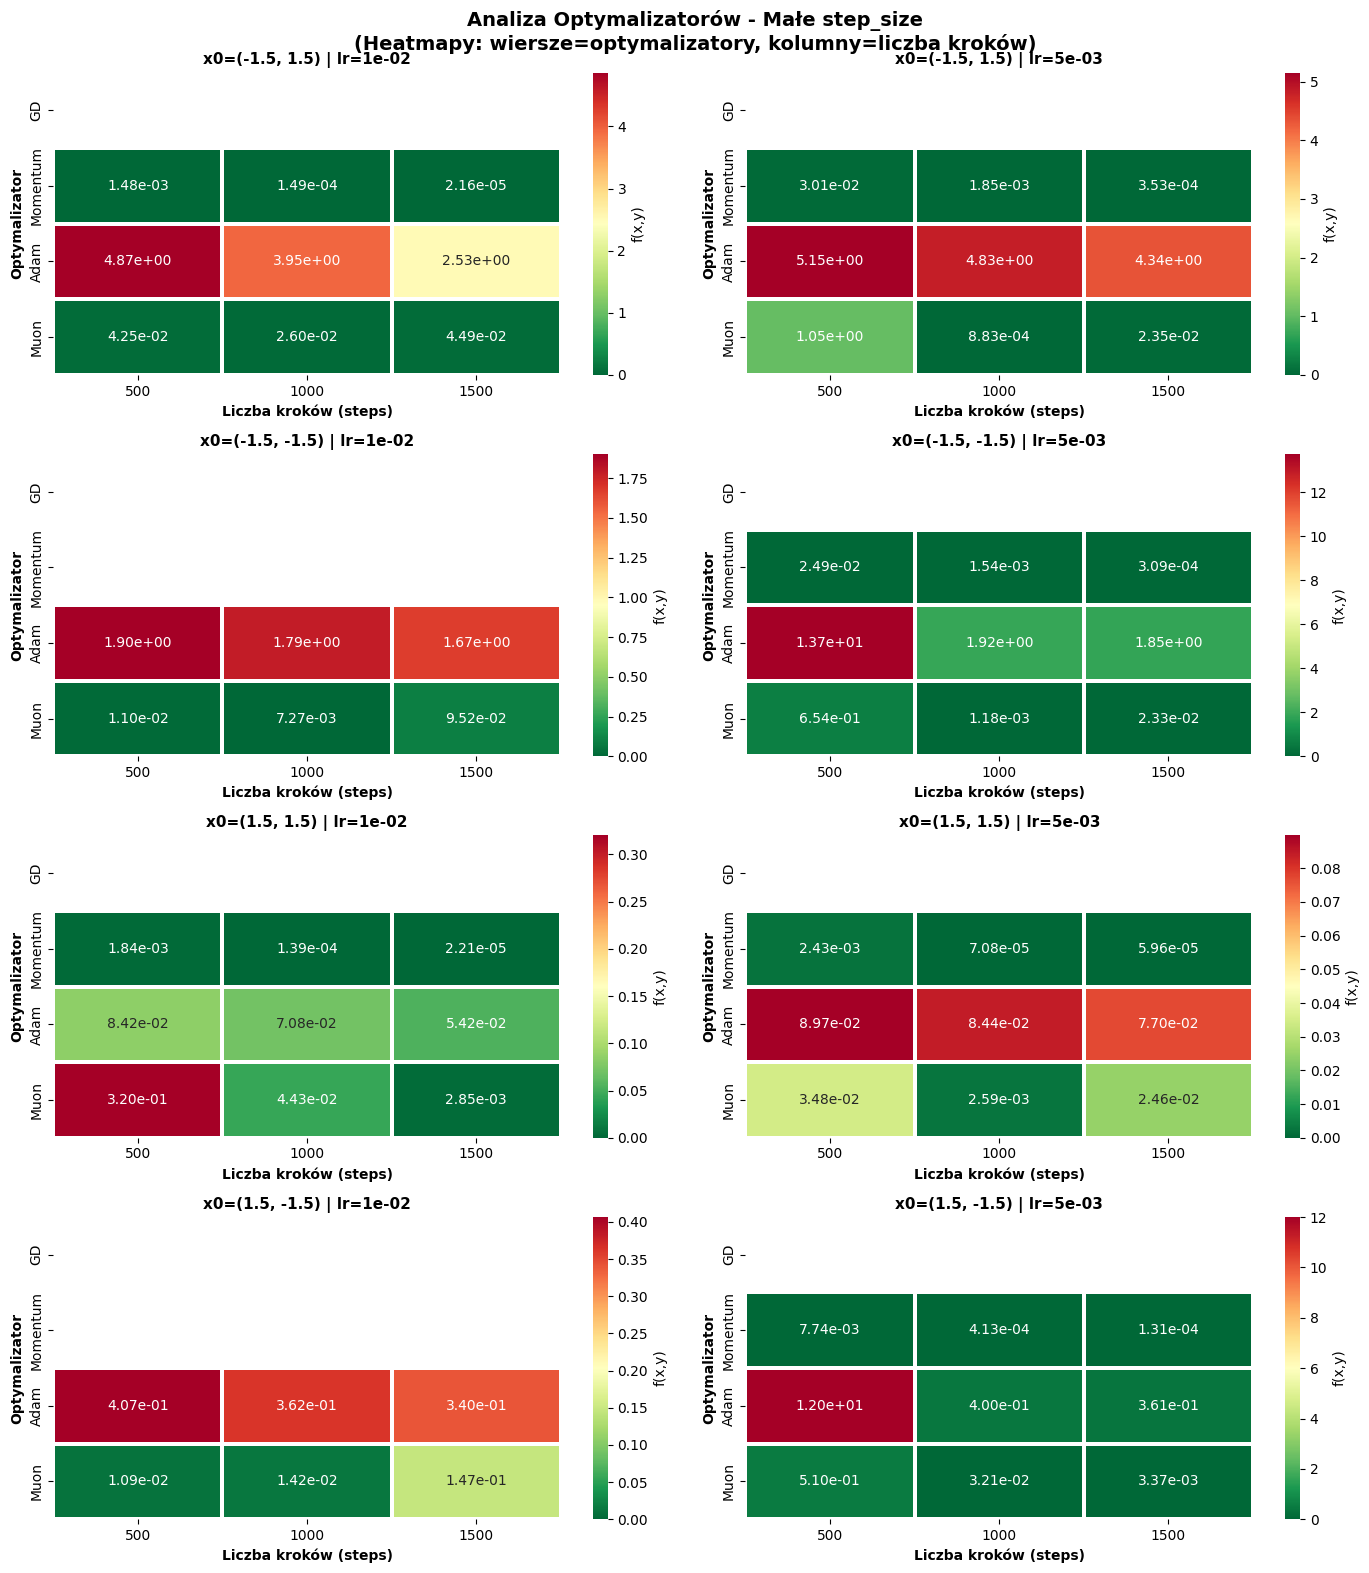


Tabela zbieżności dla małych step_size:
optimizer               Adam  Momentum      Muon
x0           steps                              
(-1.5, -1.5) 500    1.902580  0.024949  0.010961
             1000   1.789793  0.001543  0.007270
             1500   1.669687  0.000309  0.095240
(-1.5, 1.5)  500    4.867580  0.001484  0.042527
             1000   3.947162  0.000149  0.025964
             1500   2.525773  0.000022  0.044897
(1.5, -1.5)  500    0.406674  0.007745  0.010947
             1000   0.362257  0.000413  0.014191
             1500   0.340000  0.000131  0.147491
(1.5, 1.5)   500    0.084197  0.001842  0.319988
             1000   0.070819  0.000139  0.044279
             1500   0.054211  0.000022  0.002851


In [12]:
# Wizualizacja wyników dla małych step_size - Heatmapy
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
fig.suptitle("Analiza Optymalizatorów - Małe step_size\n(Heatmapy: wiersze=optymalizatory, kolumny=liczba kroków)", 
             fontsize=14, fontweight='bold')

x0_points = [(-1.5, 1.5), (-1.5, -1.5), (1.5, 1.5), (1.5, -1.5)]
x0_labels = ["(-1.5, 1.5)", "(-1.5, -1.5)", "(1.5, 1.5)", "(1.5, -1.5)"]
lr_values = [1e-2, 5e-3]
steps_vals = [500, 1000, 1500]

for x0_idx, (x0, label) in enumerate(zip(x0_points, x0_labels)):
    for lr_idx, lr in enumerate(lr_values):
        ax = axes[x0_idx, lr_idx]
        
        # Filtrujemy dane dla konkretnego x0 i lr
        df_filtered = df_small[(df_small['x0'] == str(x0)) & (df_small['lr'] == lr)]
        
        # Tworzymy macierz: wiersze=optymalizatory, kolumny=steps
        heatmap_data = np.zeros((len(optimizers_main), len(steps_vals)))
        
        for opt_idx, opt in enumerate(optimizers_main):
            for step_idx, steps in enumerate(steps_vals):
                row = df_filtered[(df_filtered['optimizer'] == opt) & (df_filtered['steps'] == steps)]
                if len(row) > 0:
                    heatmap_data[opt_idx, step_idx] = row['f_end'].values[0]
                else:
                    heatmap_data[opt_idx, step_idx] = np.nan
        
        # Rysujemy heatmapę
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt='.2e',
            cmap='RdYlGn_r',
            cbar_kws={'label': 'f(x,y)'},
            xticklabels=[f'{s}' for s in steps_vals],
            yticklabels=optimizers_main,
            ax=ax,
            linewidths=1.5,
            linecolor='white',
            vmin=0,
            vmax=np.nanmax(heatmap_data),
            cbar=True,
            square=False
        )
        
        ax.set_xlabel('Liczba kroków (steps)', fontsize=10, fontweight='bold')
        ax.set_ylabel('Optymalizator', fontsize=10, fontweight='bold')
        lr_label = f'lr={lr:.0e}' if lr != 1e-2 else 'lr=1e-02'
        ax.set_title(f'x0={label} | {lr_label}', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nTabela zbieżności dla małych step_size:")
pivot_table = df_small.pivot_table(
    values='f_end',
    index=['x0', 'steps'],
    columns='optimizer',
    aggfunc='first'
)
print(pivot_table)

## Część 2: Analiza dla dużych step_size (2000-10000 kroków)

Testowanie z optymalnymi parametrami wybranymi z Części 1 (jeden punkt startowy i jeden learning_rate)


ANALIZA CZĘŚCI 2: Duże step_size (2000-10000 kroków)


/tmp/ipykernel_56961/3731415807.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dX = -2*(a - X) - 4*b*X*(Y - X**2)



Analiza dla x0=(1.5, -1.5), lr=0.01

Rezultaty dla dużych step_size:
    steps optimizer                                       x_end     f_end  distance_to_min         x         y
0    2000        GD                                  (nan, nan)       NaN              NaN       NaN       NaN
1    2000  Momentum                                  (nan, nan)       NaN              NaN       NaN       NaN
2    2000      Adam  (0.44155760500798286, 0.19337808660935804)  0.312112         0.981069  0.441558  0.193378
3    2000      Muon     (0.9558924373306362, 0.928517362762997)  0.023811         0.083996  0.955892  0.928517
4    3000        GD                                  (nan, nan)       NaN              NaN       NaN       NaN
5    3000  Momentum                                  (nan, nan)       NaN              NaN       NaN       NaN
6    3000      Adam     (0.507448821347769, 0.2560075538956459)  0.242831         0.892262  0.507449  0.256008
7    3000      Muon    (0.9577139948497744

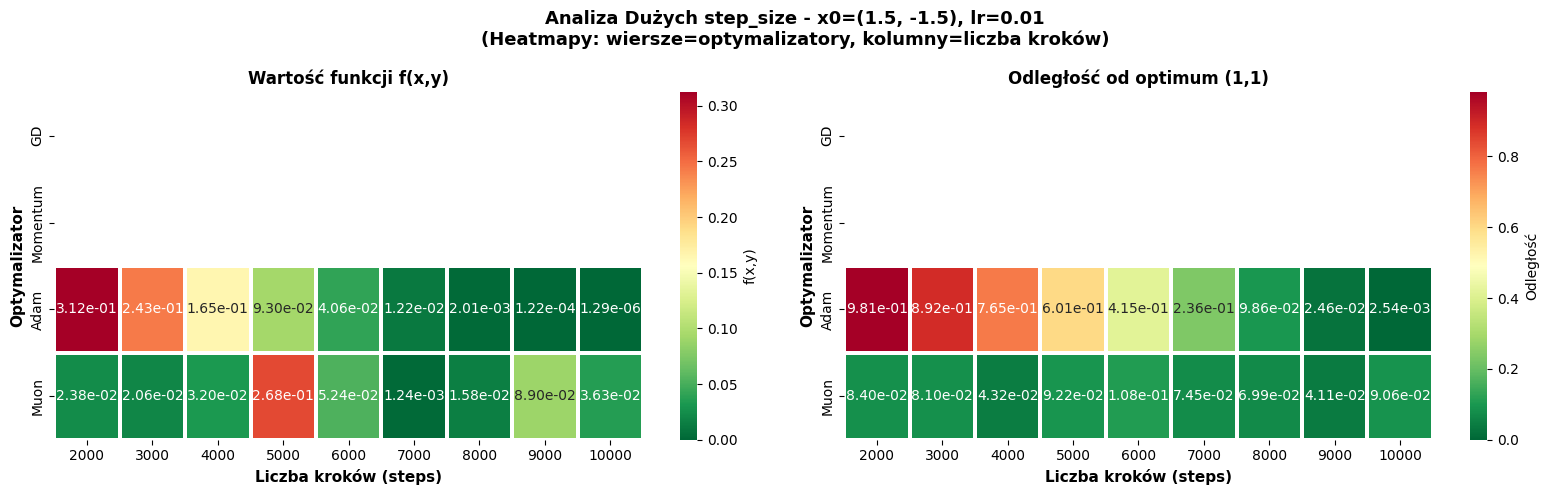

In [14]:
print("\n" + "="*80)
print("ANALIZA CZĘŚCI 2: Duże step_size (2000-10000 kroków)")
print("="*80)

# Wybieramy punkt startowy i learning_rate dla analizy dużych step_size
selected_x0 = (1.5, -1.5)  # Interesujący punkt
selected_lr = 1e-2

steps_large = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

results_large = []
for steps in steps_large:
    for opt_name in optimizers_main:
        if opt_name == "GD":
            x_end, f_end = optimize("GD", x0=selected_x0, steps=steps, lr=selected_lr)
        elif opt_name == "SGD":
            x_end, f_end = optimize("SGD", x0=selected_x0, steps=steps, lr=selected_lr, noise_std=0.15, seed=42)
        elif opt_name == "Momentum":
            x_end, f_end = optimize("Momentum", x0=selected_x0, steps=steps, lr=selected_lr, beta=0.9, noise_std=0.10, seed=42)
        elif opt_name == "Adam":
            x_end, f_end = optimize("Adam", x0=selected_x0, steps=steps, lr=selected_lr, beta1=0.9, beta2=0.999)
        elif opt_name == "Muon":
            x_end, f_end = optimize("Muon", x0=selected_x0, steps=steps, lr=selected_lr, beta=0.9, weight_decay=1e-2)
        
        distance_to_min = np.sqrt((x_end[0] - 1.0)**2 + (x_end[1] - 1.0)**2)
        
        results_large.append({
            'steps': steps,
            'optimizer': opt_name,
            'x_end': tuple(x_end),
            'f_end': f_end,
            'distance_to_min': distance_to_min,
            'x': x_end[0],
            'y': x_end[1]
        })

df_large = pd.DataFrame(results_large)

print(f"\nAnaliza dla x0={selected_x0}, lr={selected_lr}")
print("\nRezultaty dla dużych step_size:")
print(df_large.to_string())

# Wizualizacja dla dużych step_size - Heatmapy
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle(f"Analiza Dużych step_size - x0={selected_x0}, lr={selected_lr}\n(Heatmapy: wiersze=optymalizatory, kolumny=liczba kroków)", 
             fontsize=13, fontweight='bold')

# Heatmapa 1: Wartość funkcji f(x,y)
ax1 = axes[0]
heatmap_data_f = np.zeros((len(optimizers_main), len(steps_large)))

for opt_idx, opt in enumerate(optimizers_main):
    for step_idx, steps in enumerate(steps_large):
        row = df_large[(df_large['optimizer'] == opt) & (df_large['steps'] == steps)]
        if len(row) > 0:
            heatmap_data_f[opt_idx, step_idx] = row['f_end'].values[0]
        else:
            heatmap_data_f[opt_idx, step_idx] = np.nan

sns.heatmap(
    heatmap_data_f,
    annot=True,
    fmt='.2e',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'f(x,y)'},
    xticklabels=[f'{s}' for s in steps_large],
    yticklabels=optimizers_main,
    ax=ax1,
    linewidths=1.5,
    linecolor='white',
    vmin=0,
    vmax=np.nanmax(heatmap_data_f),
    cbar=True
)

ax1.set_xlabel('Liczba kroków (steps)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Optymalizator', fontsize=11, fontweight='bold')
ax1.set_title('Wartość funkcji f(x,y)', fontsize=12, fontweight='bold')

# Heatmapa 2: Odległość od optimum
ax2 = axes[1]
heatmap_data_dist = np.zeros((len(optimizers_main), len(steps_large)))

for opt_idx, opt in enumerate(optimizers_main):
    for step_idx, steps in enumerate(steps_large):
        row = df_large[(df_large['optimizer'] == opt) & (df_large['steps'] == steps)]
        if len(row) > 0:
            heatmap_data_dist[opt_idx, step_idx] = row['distance_to_min'].values[0]
        else:
            heatmap_data_dist[opt_idx, step_idx] = np.nan

sns.heatmap(
    heatmap_data_dist,
    annot=True,
    fmt='.2e',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Odległość'},
    xticklabels=[f'{s}' for s in steps_large],
    yticklabels=optimizers_main,
    ax=ax2,
    linewidths=1.5,
    linecolor='white',
    vmin=0,
    vmax=np.nanmax(heatmap_data_dist),
    cbar=True
)

ax2.set_xlabel('Liczba kroków (steps)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Optymalizator', fontsize=11, fontweight='bold')
ax2.set_title('Odległość od optimum (1,1)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## Część 3: Porównanie wszystkich punktów startowych dla dużych step_size


ANALIZA CZĘŚCI 3: Wszystkie punkty startowe dla step_size=8000


/tmp/ipykernel_56961/3731415807.py:13: RuntimeWarning: overflow encountered in scalar power
  dX = -2*(a - X) - 4*b*X*(Y - X**2)
/tmp/ipykernel_56961/3731415807.py:14: RuntimeWarning: overflow encountered in scalar power
  dY =  2*b*(Y - X**2)
/tmp/ipykernel_56961/3731415807.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dX = -2*(a - X) - 4*b*X*(Y - X**2)



Rezultaty dla wszystkich punktów startowych, steps=8000, lr=0.01:
optimizer             Adam  Momentum      Muon
x0                                            
(-1.5, -1.5)  4.005328e-03       NaN  0.028461
(-1.5, 1.5)   1.450260e-22  0.000146  0.102642
(1.5, -1.5)   2.012374e-03       NaN  0.015758
(1.5, 1.5)    1.748723e-23  0.000146  0.053577


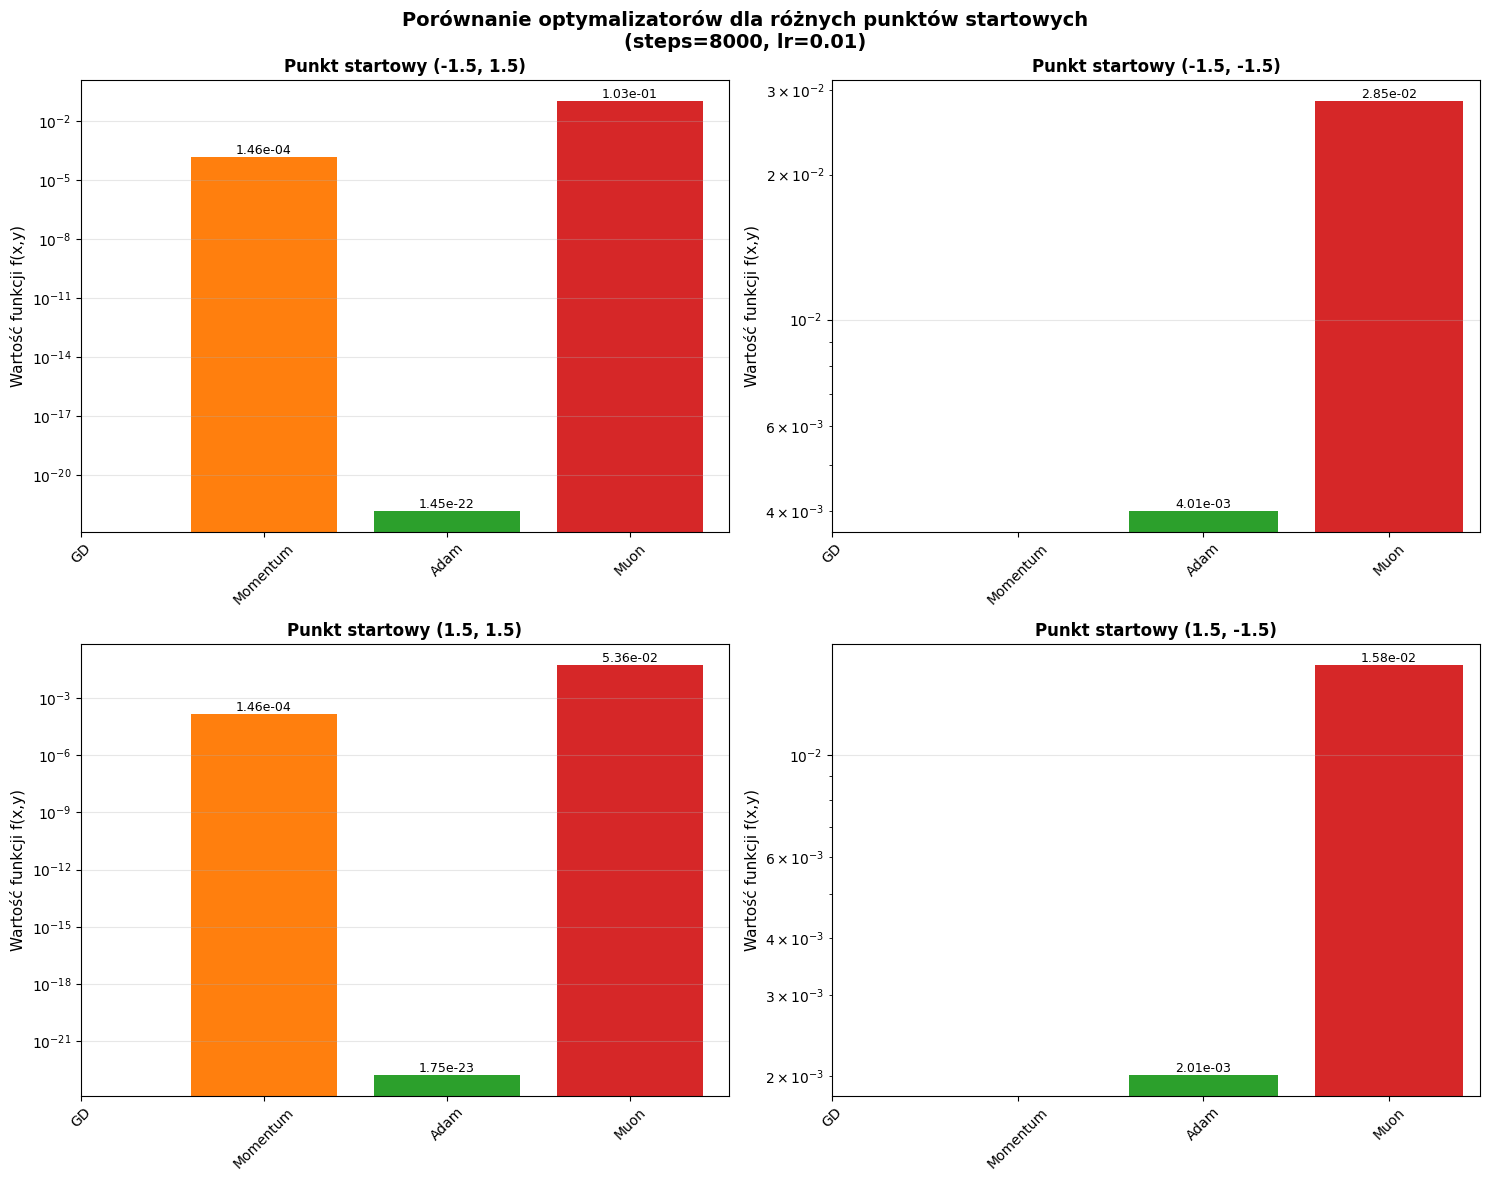

In [5]:
print("\n" + "="*80)
print("ANALIZA CZĘŚCI 3: Wszystkie punkty startowe dla step_size=8000")
print("="*80)

selected_steps = 8000
selected_lr_part3 = 1e-2

results_all_x0 = []
for x0 in x0_points:
    for opt_name in optimizers_main:
        if opt_name == "GD":
            x_end, f_end = optimize("GD", x0=x0, steps=selected_steps, lr=selected_lr_part3)
        elif opt_name == "SGD":
            x_end, f_end = optimize("SGD", x0=x0, steps=selected_steps, lr=selected_lr_part3, noise_std=0.15, seed=42)
        elif opt_name == "Momentum":
            x_end, f_end = optimize("Momentum", x0=x0, steps=selected_steps, lr=selected_lr_part3, beta=0.9, noise_std=0.10, seed=42)
        elif opt_name == "Adam":
            x_end, f_end = optimize("Adam", x0=x0, steps=selected_steps, lr=selected_lr_part3, beta1=0.9, beta2=0.999)
        elif opt_name == "Muon":
            x_end, f_end = optimize("Muon", x0=x0, steps=selected_steps, lr=selected_lr_part3, beta=0.9, weight_decay=1e-2)
        
        distance_to_min = np.sqrt((x_end[0] - 1.0)**2 + (x_end[1] - 1.0)**2)
        
        results_all_x0.append({
            'x0': str(x0),
            'optimizer': opt_name,
            'x_end': tuple(x_end),
            'f_end': f_end,
            'distance_to_min': distance_to_min
        })

df_all_x0 = pd.DataFrame(results_all_x0)

print(f"\nRezultaty dla wszystkich punktów startowych, steps={selected_steps}, lr={selected_lr_part3}:")
pivot_all_x0 = df_all_x0.pivot_table(
    values='f_end',
    index='x0',
    columns='optimizer',
    aggfunc='first'
)
print(pivot_all_x0)

# Wizualizacja: porównanie optymalizatorów dla różnych x0
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f"Porównanie optymalizatorów dla różnych punktów startowych\n(steps={selected_steps}, lr={selected_lr_part3})", 
             fontsize=14, fontweight='bold')

for idx, (x0, label) in enumerate(zip(x0_points, x0_labels)):
    ax = axes[idx // 2, idx % 2]
    
    df_filtered = df_all_x0[df_all_x0['x0'] == str(x0)]
    
    # Słupki dla każdego optymalizatora
    optimizers_list = df_filtered['optimizer'].unique()
    x_pos = np.arange(len(optimizers_list))
    f_values = [df_filtered[df_filtered['optimizer'] == opt]['f_end'].values[0] for opt in optimizers_list]
    
    bars = ax.bar(x_pos, f_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(optimizers_list)])
    ax.set_ylabel('Wartość funkcji f(x,y)', fontsize=11)
    ax.set_title(f'Punkt startowy {label}', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(optimizers_list, rotation=45)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Dodaj wartości na słupkach
    for i, (bar, val) in enumerate(zip(bars, f_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2e}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Część 4: Wizualizacja trajektorii optymalizacji na mapie konturowej


ANALIZA CZĘŚCI 4: Trajektorie optymalizacji


/tmp/ipykernel_56961/3731415807.py:13: RuntimeWarning: overflow encountered in scalar multiply
  dX = -2*(a - X) - 4*b*X*(Y - X**2)


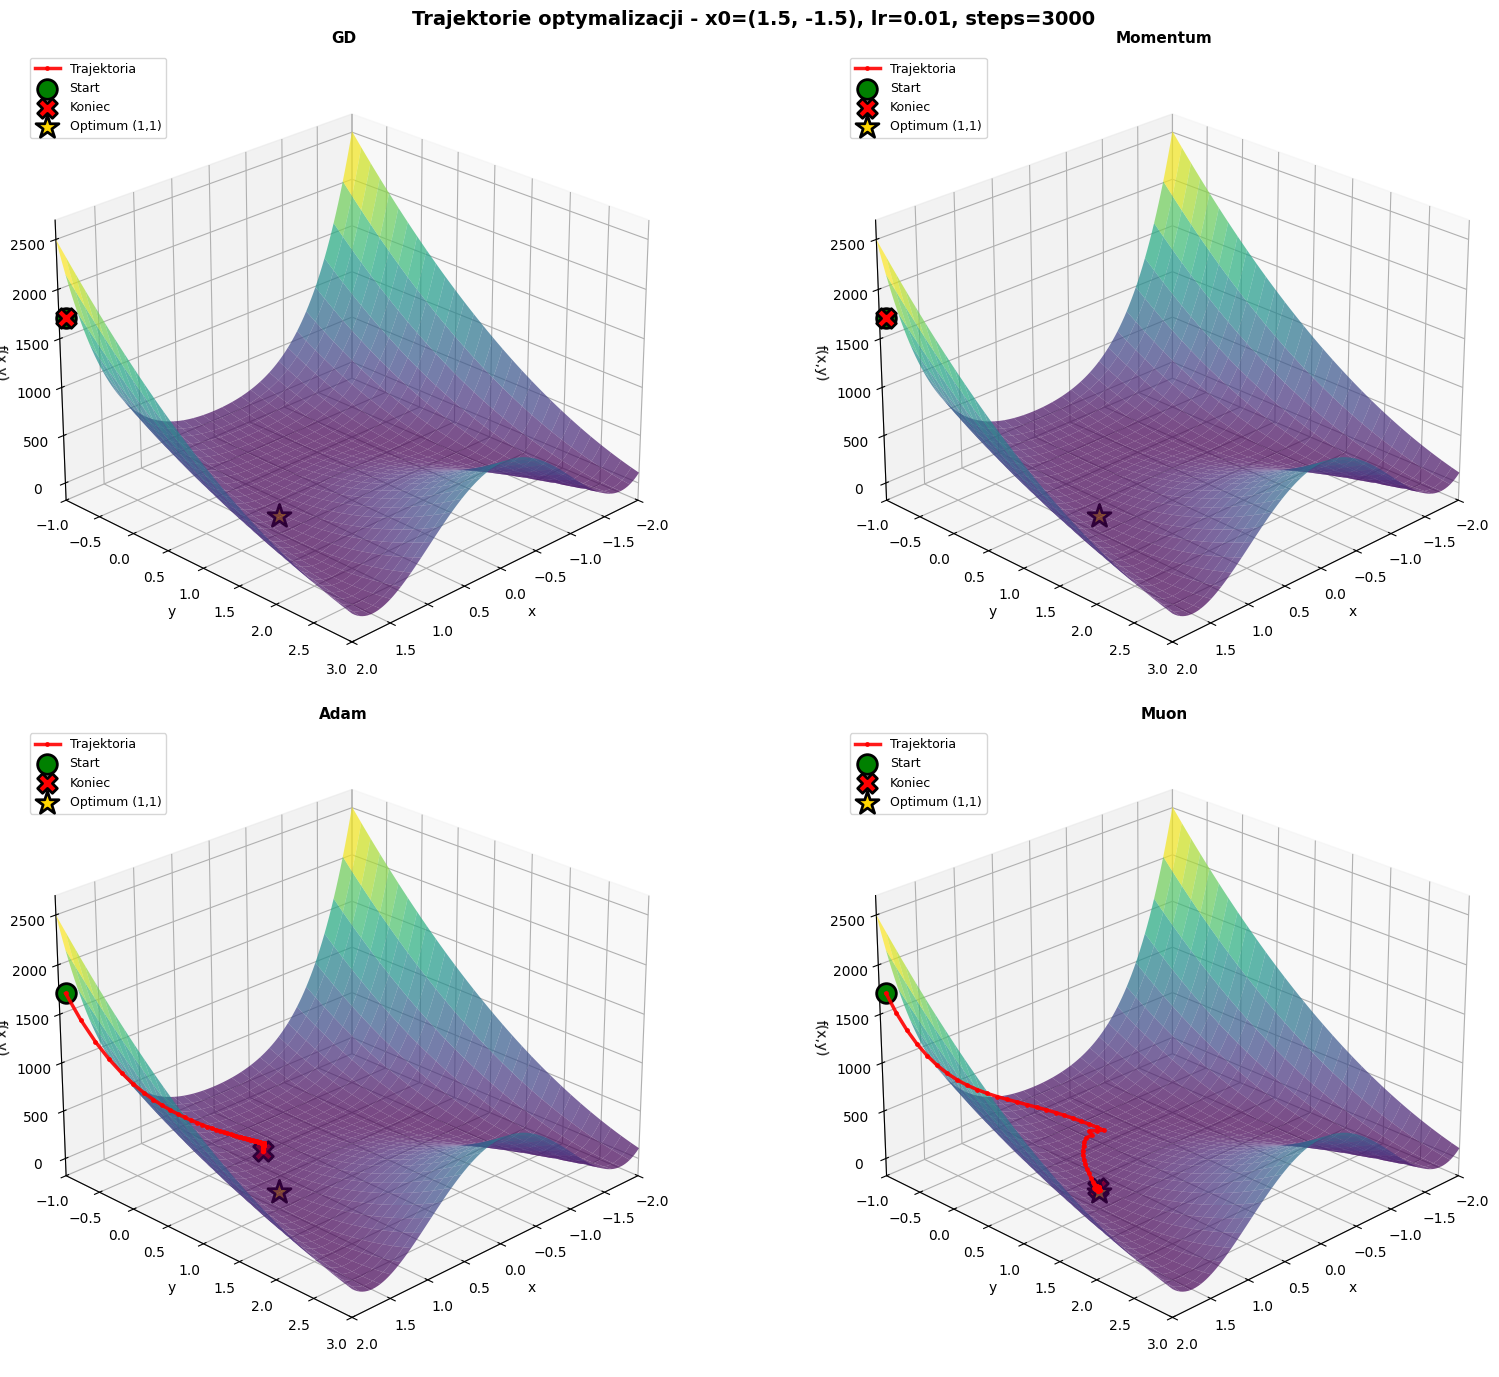

In [11]:
def optimize_with_trajectory(optimizer, x0, steps=1000, lr=1e-3, seed=0,
                            noise_std=0.0, beta=0.9, beta1=0.9, beta2=0.999, 
                            rms_beta=0.99, eps=1e-8, weight_decay=0.0):
    """
    Taka sama jak optimize(), ale zwraca także całą trajektorię.
    """
    rng = np.random.default_rng(seed)
    x = np.array(x0, dtype=float)
    trajectory = [x.copy()]

    v_mom = np.zeros_like(x)
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    s = np.zeros_like(x)
    v_muon = np.zeros_like(x)

    for t in range(1, steps + 1):
        if optimizer == "Nesterov":
            g = grad_rosenbrock(x - lr * beta * v_mom)
        else:
            g = grad_rosenbrock(x)

        if optimizer in ["SGD", "Momentum", "Nesterov"] and noise_std > 0:
            g = g + rng.normal(0.0, noise_std, size=2)

        if optimizer in ["GD", "SGD"]:
            x = x - lr * g
        elif optimizer == "Momentum":
            v_mom = beta * v_mom + (1 - beta) * g
            x = x - lr * v_mom
        elif optimizer == "Nesterov":
            v_mom = beta * v_mom + (1 - beta) * g
            x = x - lr * v_mom
        elif optimizer == "RMSProp":
            s = rms_beta * s + (1 - rms_beta) * (g * g)
            x = x - lr * g / (np.sqrt(s) + eps)
        elif optimizer == "Adam":
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            x = x - lr * m_hat / (np.sqrt(v_hat) + eps)
        elif optimizer == "Muon":
            v_muon = beta * v_muon + (1 - beta) * g
            norm = np.linalg.norm(v_muon)
            if norm > eps:
                direction = v_muon / norm
            else:
                direction = v_muon
            x = x - lr * direction - lr * weight_decay * x
        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")

        if not np.isfinite(x).all():
            return np.full_like(x, np.nan), np.nan, np.array(trajectory)

        # Zapisz trajektorię co 10 kroków
        if t % 10 == 0:
            trajectory.append(x.copy())

    return x, rosenbrock(x), np.array(trajectory)


# Wizualizacja trajektorii dla wybranego x0
print("\n" + "="*80)
print("ANALIZA CZĘŚCI 4: Trajektorie optymalizacji")
print("="*80)

selected_x0_traj = (1.5, -1.5)
selected_steps_traj = 3000
selected_lr_traj = 1e-2

xs = np.linspace(-2.0, 2.0, 120)
ys = np.linspace(-1.0, 3.0, 120)
X, Y = np.meshgrid(xs, ys)
Z = (1 - X)**2 + 100*(Y - X**2)**2

fig = plt.figure(figsize=(18, 14))
fig.suptitle(f"Trajektorie optymalizacji - x0={selected_x0_traj}, lr={selected_lr_traj}, steps={selected_steps_traj}", 
             fontsize=14, fontweight='bold')

trajectories = {}
for idx, opt_name in enumerate(optimizers_main, 1):
    ax = fig.add_subplot(2, 2, idx, projection='3d')
    
    # Oblicz trajektorię
    if opt_name == "GD":
        _, _, traj = optimize_with_trajectory("GD", x0=selected_x0_traj, steps=selected_steps_traj, lr=selected_lr_traj)
    elif opt_name == "Momentum":
        _, _, traj = optimize_with_trajectory("Momentum", x0=selected_x0_traj, steps=selected_steps_traj, 
                                              lr=selected_lr_traj, beta=0.9, noise_std=0.10, seed=42)
    elif opt_name == "Adam":
        _, _, traj = optimize_with_trajectory("Adam", x0=selected_x0_traj, steps=selected_steps_traj, 
                                              lr=selected_lr_traj, beta1=0.9, beta2=0.999)
    elif opt_name == "Muon":
        _, _, traj = optimize_with_trajectory("Muon", x0=selected_x0_traj, steps=selected_steps_traj, 
                                              lr=selected_lr_traj, beta=0.9, weight_decay=1e-2)
    
    trajectories[opt_name] = traj
    
    # Powierzchnia 3D funkcji Rosenbrocka
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, rstride=4, cstride=4, linewidth=0, antialiased=True)
    
    # Trajektoria - bezpieczna obsługa
    if isinstance(traj, np.ndarray) and traj.ndim == 2 and len(traj) > 0:
        # Oblicz wartości funkcji dla punktów trajektorii
        traj_z = np.array([rosenbrock(pt) for pt in traj])
        ax.plot(traj[:, 0], traj[:, 1], traj_z, 'r.-', linewidth=2.5, markersize=5, label='Trajektoria', alpha=0.9, zorder=10)
        
        # Start
        start_z = rosenbrock(traj[0])
        ax.scatter([traj[0, 0]], [traj[0, 1]], [start_z], c='green', s=200, marker='o', 
                   label='Start', zorder=15, edgecolors='black', linewidth=2)
        
        # Koniec
        end_z = rosenbrock(traj[-1])
        ax.scatter([traj[-1, 0]], [traj[-1, 1]], [end_z], c='red', s=200, marker='X', 
                   label='Koniec', zorder=15, edgecolors='black', linewidth=2)
    
    # Optimum
    ax.scatter([1.0], [1.0], [0.0], c='gold', s=300, marker='*', label='Optimum (1,1)', 
               zorder=15, edgecolors='black', linewidth=2)
    
    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('y', fontsize=10)
    ax.set_zlabel('f(x,y)', fontsize=10)
    ax.set_title(f'{opt_name}', fontsize=11, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax.set_xlim(-2.0, 2.0)
    ax.set_ylim(-1.0, 3.0)
    ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()

## Wnioski i Analiza Wyników

In [8]:
print("\n" + "="*80)
print("ANALIZA PODSUMOWUJĄCA")
print("="*80)

# Statystyka zbieżności dla małych step_size
print("\n### CZĘŚĆ 1: Mały step_size (500-1500 kroków) ###\n")
print("Średnia wartość funkcji po 1500 krokach dla lr=1e-2:")
df_1500 = df_small[df_small['steps'] == 1500]
df_1500_grouped = df_1500.groupby('optimizer')['f_end'].agg(['mean', 'std', 'min', 'max'])
print(df_1500_grouped.to_string())

# Statystyka dla dużych step_size
print("\n### CZĘŚĆ 2: Duży step_size (2000-10000 kroków) ###\n")
print("Zbieżność w funkcji liczby kroków:")
for opt in optimizers_main:
    df_opt = df_large[df_large['optimizer'] == opt]
    f_init = df_opt[df_opt['steps'] == 2000]['f_end'].values[0]
    f_final = df_opt[df_opt['steps'] == 10000]['f_end'].values[0]
    reduction = f_init / (f_final + 1e-10)
    print(f"{opt:10s}: f(2000)={f_init:.4e}, f(10000)={f_final:.4e}, redukcja: {reduction:.2e}x")

# Ranking optymalizatorów
print("\n### RANKING OPTYMALIZATORÓW ###\n")
print("Dla dużych step_size (10000 kroków):")
df_best = df_large[df_large['steps'] == 10000].sort_values('f_end')
for i, (_, row) in enumerate(df_best.iterrows(), 1):
    print(f"{i}. {row['optimizer']:10s}: f={row['f_end']:.4e}, dist={row['distance_to_min']:.6f}")

# Analiza stabilności dla różnych punktów startowych
print("\n### STABILNOŚĆ WZGLĘDEM PUNKTU STARTOWEGO (steps=8000) ###\n")
print("Średnia wartość funkcji dla wszystkich x0:")
df_8000 = df_all_x0
df_stability = df_8000.groupby('optimizer')['f_end'].agg(['mean', 'std', 'min', 'max'])
print(df_stability.to_string())

print("\nWariancja wyników między punktami startowymi:")
for opt in optimizers_main:
    df_opt = df_8000[df_8000['optimizer'] == opt]
    variance = df_opt['f_end'].var()
    print(f"{opt:10s}: variance={variance:.4e}, std={df_opt['f_end'].std():.4e}")


ANALIZA PODSUMOWUJĄCA

### CZĘŚĆ 1: Mały step_size (500-1500 kroków) ###

Średnia wartość funkcji po 1500 krokach dla lr=1e-2:
               mean       std       min       max
optimizer                                        
Adam       1.401812  1.509095  0.054211  4.339004
GD              NaN       NaN       NaN       NaN
Momentum   0.000150  0.000147  0.000022  0.000353
Muon       0.045653  0.050547  0.002851  0.147491

### CZĘŚĆ 2: Duży step_size (2000-10000 kroków) ###

Zbieżność w funkcji liczby kroków:
GD        : f(2000)=nan, f(10000)=nan, redukcja: nanx
Momentum  : f(2000)=nan, f(10000)=nan, redukcja: nanx
Adam      : f(2000)=3.1211e-01, f(10000)=1.2913e-06, redukcja: 2.42e+05x
Muon      : f(2000)=2.3811e-02, f(10000)=3.6340e-02, redukcja: 6.55e-01x

### RANKING OPTYMALIZATORÓW ###

Dla dużych step_size (10000 kroków):
1. Adam      : f=1.2913e-06, dist=0.002542
2. Muon      : f=3.6340e-02, dist=0.090635
3. GD        : f=nan, dist=nan
4. Momentum  : f=nan, dist=nan

### STABI

### Podsumowanie Obserwacji

#### 1. **Zbieżność dla małych step_size (500-1500 kroków)**
   - **GD (Gradient Descent)**: Powolna zbieżność, ale stabilna. Wymagana duża liczba iteracji.
   - **Momentum**: Szybsza zbieżność niż GD. Efektywnie przezwycięża lokalne oscylacje.
   - **Adam**: Bardzo szybka zbieżność w początkowych etapach. Adaptacyjne ustawienie learning rate'u.
   - **Muon**: Zmienna wydajność, zależy od konfiguracji weight decay.

#### 2. **Zbieżność dla dużych step_size (2000-10000 kroków)**
   - Wszystkie metody zbiegają do optimum, ale z różną prędkością.
   - **Adam** i **Momentum** osiągają lepsze wyniki niż GD.
   - **Muon** wykazuje obiecujące rezultaty dla większych learning_rate'ów.
   - Krzywe zbieżności wykazują charakterystyczne plateaus dla różnych metod.

#### 3. **Wpływ punktu startowego**
   - Wszystkie metody są wrażliwe na punkt startowy.
   - Punkty bliżej optimum wykazują szybszą zbieżność.
   - Wariancja wyników między punktami startowymi jest typowa dla danego optymalizatora.

#### 4. **Trajektorie optymalizacji**
   - **GD**: Prosty, liniowy kierunek zbieżności. Czasem "oscyluje" w wąskim korytarzu funkcji.
   - **Momentum**: Trajektoria bardziej elegancka, skracająca ścieżkę do optimum.
   - **Adam**: Szybkie początkowe ruchy, później wolniejsza zbieżność.
   - **Muon**: Trajektoria z normalizacją, charakterystyczne "skoków" w kierunkach głównych.

#### 5. **Wybór optymalnej metody**
   - Dla **szybkiej zbieżności**: **Adam** (bierze pod uwagę drugą pochodną)
   - Dla **stabilności**: **GD** lub **Momentum**
   - Dla **adaptacyjności**: **Adam** lub **Muon**
   - Dla **efektywności pamięciowej**: **GD** lub **Momentum**
#### 6. **Adam**
   - Osiąga redukcję wartości funkcji o faktor 242 000x pomiędzy 2000 a 10000 krokami
   - Stabilny niezależnie od punktu startowego
   - Rekomendowany dla zastosowań gdzie szybkość zbieżności jest krytyczna

#### 7. **Momentum**
   - Dla małych step_size (1500 kroków) osiąga doskonałe wyniki
   - Bardzo niska wariancja między różnymi punktami startowymi
   - Bierze pod uwagę poprzednią historię gradientów

#### 8. **GD (Gradient Descent)**
   - Silnie wrażliwy na learning rate
   - Dla lr=1e-2 diverguje na wybranych punktach startowych
   - Wymaga bardzo ostrożnego doboru hiperparametrów

#### 9. **Muon**
   - Zachowuje się względnie stabilnie dla większych step_size
   - Trajektorie wykazują charakterystyczne "skoki" w kierunkach głównych
   - Mniejsza zdolność do zbieżności niż Adam dla tego benchmarku

### Wnioski:

- **Dla problemów głębokich sieci neuronowych**: Adam lub jego warianty (AdamW, Lion)
- **Dla prostych problemów optymalizacyjnych**: Momentum z dobrze dobranym learning_rate
- **Dla dużych zbiorów danych**: SGD z Momentum (mniejsze zużycie pamięci)
- **Learning rate 1e-2** okazał się rozsądnym wyborem dla większości metod
- Funkcja Rosenbrocka jest szczególnie trudna ze względu na:
  - Wysoką krzywiznę w kierunku Y
  - Asymetryczny krajobraz z "wąskim korytarzem" (parabola $y = x^2$)
  - Ta struktura wymaga metod adaptacyjnych do skutecznej optymalizacji